<div class="alert alert-block alert-info">
<b>Note:</b> The goal of this notebook is to show you how to work with the Bayesian Statistics Toolbox (BST) when performing an analysis that involves comparing the effect of multiple nominal predictors on a metric outcome (think two-way and mixed-model ANOVAs) that may be normally or non-normally distributed (the "robust" version). These models utilize multi-level (hierarchical) modeling, one of the great strengths of Bayesian modeling. This is an adaptation of Jordi Warmenhoven's PyMC3 port of Chapter 20 of John Kruschke's textbook "Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan" (https://github.com/JWarmenhoven/DBDA-python). Please note that the code has been updated to make use of PyMC4 and that this does not (yet) include all of the examples from the original. </div>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
import aesara.tensor as at

# Import BST
import src.bayesian_stats as bst

from IPython.display import Image

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95

In [ ]:
df = pd.read_csv('data/HtWtData110.csv')
df.info()

In [ ]:
X = df[["weight", "height"]]
y = df["male"]

zX, mu_X, sigma_X = bst.standardize(X)

### Kruschke-style graphical model 

In [ ]:
Image('images/fig21_2.png')

In [ ]:
def bayesian_logistic_regression(X, y, n_draws=1000):
    
    # Standardize the predictor variable(s)
    zX, mu_X, sigma_X = bst.standardize(X)
    
    with pm.Model(coords={"predictors": X.columns.values}) as model:
        # Set  priors
        zbeta0 = pm.Normal("zbeta0", mu=0, sigma=2)
        zbetaj = pm.Normal("zbetaj", mu=0, sigma=2, dims="predictors")
        
        p = pm.invlogit(zbeta0 + pm.math.dot(zX, zbetaj))
        
        # Define likelihood function
        likelihood = pm.Bernoulli("likelihood", p, observed=y)
        
        # Transform parameters to original scale
        beta0 = pm.Deterministic("beta0", (zbeta0 - pm.math.sum(zbetaj * mu_X / sigma_X)))
        betaj = pm.Deterministic("betaj", zbetaj / sigma_X, dims="predictors")                         
        
        # Sample from the posterior
        idata = pm.sample(draws=n_draws)
        
        return model, idata

In [ ]:
# Fit your Bayesian model using BST
model, idata = bayesian_logistic_regression(X, y, n_draws=3000)

In [ ]:
az.plot_trace(idata);

In [ ]:
idata

In [ ]:
az.plot_posterior(idata, kind="hist", bins=50, point_estimate="mode", round_to=3, coords={"predictors": ["weight", "height"]});

Next steps include chimpanzee example from Ch. 11 of Statistical Rethinking (2nd ed.), where there is a separate intercept parameter for each participant and also a nominal predictor, and extending the example to include a metric predictor (think proprioception problem). 

#### Code 11.1

In [3]:
# These data are from Statistical Rethinking 2
d = pd.read_csv("Data/chimpanzees.csv", sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1
d


,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,0,NaN,0,1,2,0,1,0
1,0,NaN,0,1,4,0,0,1
2,0,NaN,0,1,6,1,0,0
3,0,NaN,0,1,8,0,1,0
4,0,NaN,0,1,10,1,1,1
...,...,...,...,...,...,...,...,...
499,6,4.0,1,6,64,1,1,1
500,6,6.0,1,6,66,1,1,1
501,6,3.0,1,6,68,0,0,1
502,6,7.0,1,6,70,0,0,1


#### Code 11.2

In [4]:
d["treatment"] = d.prosoc_left + 2 * d.condition
d[["actor", "prosoc_left", "condition", "treatment"]]

,actor,prosoc_left,condition,treatment
0,0,0,0,0
1,0,0,0,0
2,0,1,0,1
3,0,0,0,0
4,0,1,0,1
...,...,...,...,...
499,6,1,1,3
500,6,1,1,3
501,6,0,1,2
502,6,0,1,2


### Code 11.3

In [5]:
d.groupby("treatment").first()[["prosoc_left", "condition"]]

,prosoc_left,condition
treatment,,
0,0,0
1,1,0
2,0,1
3,1,1


In [7]:
actor_idx, actors = pd.factorize(d.actor)
actor_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [22]:
def bayesian_logistic_regression_subjID(subj, X, y, n_draws=1000):
    
    subj_idx, subj_levels, n_subj = bst.parse_categorical(subj)
    treatment_idx, treatment_levels, n_treatment = bst.parse_categorical(X)
    
    with pm.Model(coords={"subj": subj_levels, "treatment": treatment_levels}) as model:
        # Set priors
        a = pm.Normal("a", 0.0, 1.5, dims="subj")
        b = pm.Normal("b", 0.0, 0.5, dims="treatment")

        p = pm.Deterministic("p", pm.math.invlogit(a[subj_idx] + b[treatment_idx]))
        
        # Define likelihood function (in this case, observations are 0 or 1)
        likelihood = pm.Binomial("likelihood", 1, p, observed=y)
        
        # Draw samples from the posterior
        idata = pm.sample(draws=n_draws)
        
        return model, idata

In [11]:
model2, idata2 = bayesian_logistic_regression_subjID(d.actor, d.treatment, d.pulled_left)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [12]:
az.summary(idata2, var_names=["a", "b"], round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.45,0.33,-1.06,0.22,0.01,0.01,1873.75,2977.30,1.0
a[1],3.90,0.74,2.64,5.49,0.01,0.01,3910.90,2547.34,1.0
a[2],-0.74,0.34,-1.44,-0.11,0.01,0.01,2050.27,2725.23,1.0
a[3],-0.75,0.34,-1.43,-0.09,0.01,0.01,2052.03,2612.79,1.0
a[4],-0.45,0.32,-1.10,0.17,0.01,0.01,1802.92,2281.58,1.0
a[5],0.48,0.33,-0.15,1.12,0.01,0.01,1938.76,2158.32,1.0
a[6],1.96,0.42,1.09,2.77,0.01,0.01,2457.60,2500.06,1.0
b[0],-0.04,0.28,-0.61,0.48,0.01,0.00,1725.89,2364.10,1.0
b[1],0.48,0.28,-0.08,0.99,0.01,0.00,1728.95,2469.05,1.0
b[2],-0.39,0.28,-0.98,0.13,0.01,0.00,1597.31,2277.50,1.0


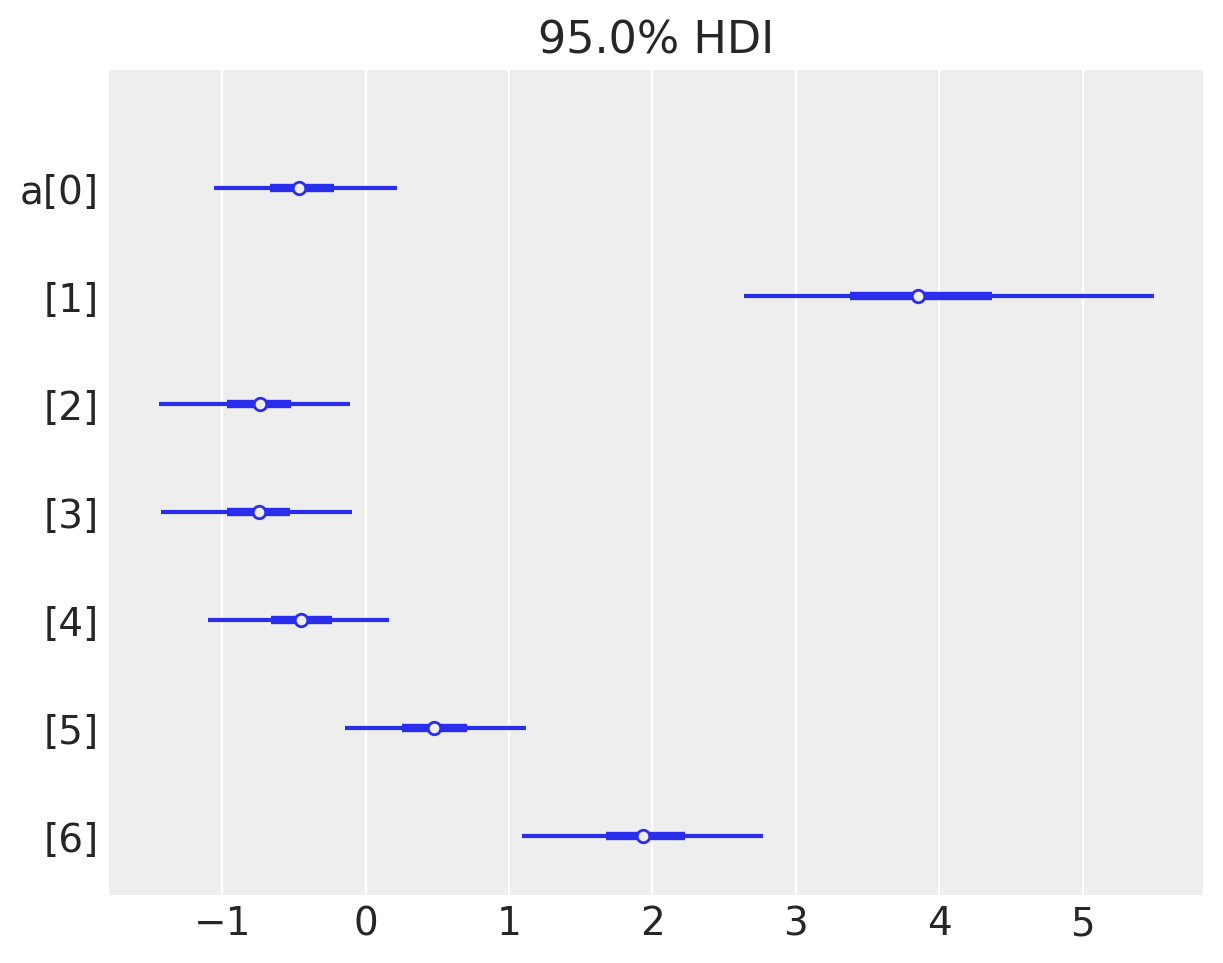

In [19]:
# TODO: Figure out how to enter logistic as input argument for "transform"
az.plot_forest(idata2, var_names=["a"], combined=True);

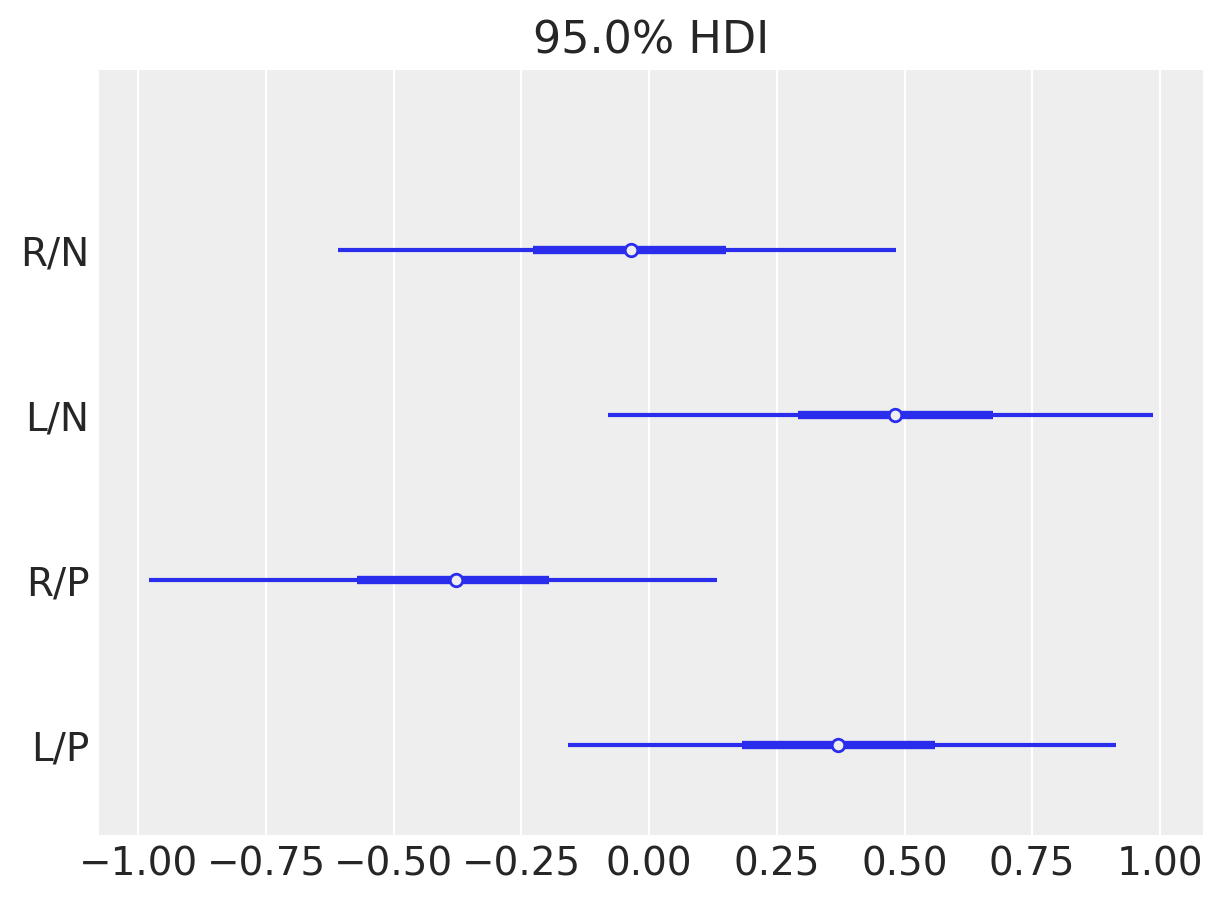

In [21]:
ax = az.plot_forest(idata2, var_names=["b"], combined=True)
ax[0].set_yticklabels(["L/P", "R/P", "L/N", "R/N"]);